In [1]:
# import os
# os.chdir("/Users/zhihanyang/Desktop/projects/gradient-gmm/src")

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from ggmm import GMM
import math

%config InlineBackend.figure_formats = ['svg']

ModuleNotFoundError: No module named 'ggmm'

## Potential functions 

In [4]:
def w1(z): return torch.sin(2 * torch.pi * z[:, 0] / 4)                 
def w2(z): return 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.5) ** 2)
def σ(x): return 1 / (1 + torch.exp(-x))
def w3(z): return 3 * σ((z[:, 0] - 1) / 0.3)

In [5]:
def taper(z):
    return torch.sigmoid(
        ( 5 - torch.linalg.vector_norm(z, dim=1, ord=np.inf) ) * 10
    )

In [6]:
def add_taper(potential):
    def new_potential(z):
        # so density is exp(-potential(z) + log(taper(z))) = exp(-potential(z)) * taper(z)
        return potential(z) - torch.log(taper(z))
    return new_potential

In [7]:
def safe_log(x):
    return torch.log(x + 1e-5)

In [8]:
def U1(z):
    part_1 = (1/2) * ((torch.sqrt(z[:,0] ** 2 + z[:,1]**2) - 2) / 0.4) ** 2
    part_2 = safe_log(
        torch.exp(-0.5 * ((z[:,0] - 2) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + 2) / 0.6) ** 2)
    )
    return (part_1 - part_2)

In [9]:
@add_taper
def U2(z):
    return ((1/2) * ((z[:,1] - w1(z)) / 0.4) ** 2)

In [10]:
@add_taper
def U3(z):
    return - safe_log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    )

In [11]:
@add_taper
def U4(z):
    return - safe_log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.34) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    )

In [12]:
def U_with_argument(z, angle, distance):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = safe_log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2)
    )
    return (term1 - term2)

In [13]:
def U8(z):
    return U_with_argument(z, torch.pi/4, 3) / 4 + \
           U_with_argument(z, torch.pi / 2 + torch.pi/4, 3) / 4 + \
           U_with_argument(z, 0, 3) / 4 + \
           U_with_argument(z, torch.pi / 2, 3) / 4

In [187]:
potential = "U1"

if potential == "U1":
    U = U1
    K = 4
elif potential == "U2":
    U = U2
    K = 10
elif potential == "U3":
    U = U3
    K = 20
elif potential == "U4":
    U = U4
    K = 30
elif potential == "U8":
    U = U8
    K = 30

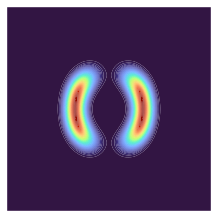

In [201]:
fig = plt.figure(figsize=(3.75, 3.75))

xs = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, xs)
xxs2, yys2 = xxs.reshape(-1, 1), yys.reshape(-1, 1)
unnorm_p = torch.exp(- U(torch.hstack([xxs2, yys2]))) #* decay(torch.hstack([xxs2, yys2]))

plt.contourf(xxs.numpy(), yys.numpy(), unnorm_p.reshape(100, 100).numpy(), levels=100, cmap="turbo")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("attempt2.png", dpi=300)

In [189]:
q = GMM(
    D=2, 
    K=K, 
    μs_init_min_and_max=torch.tensor([
        [-6., -6.], 
        [6., 6.]]
    )
)
opt = optim.Adam(q.parameters(), lr=1e-2)

μs_init = q.μs.detach().numpy().copy()
N = 1000
N_per_gaussian = math.ceil(N / K)

sample_kls = []

for i in range(1, 20001):

    sample_kl = q.compute_kl(log_unnorm_p=lambda x : -U(x), N_per_gaussian=N_per_gaussian)
    
    sample_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward()
    opt.step()

    if i % 1000 == 0:

        print(i, sum(sample_kls[-30:]) / 30)

1000 -1.5687149961789448
2000 -1.657366947333018
3000 -1.6729296803474427
4000 -1.6824694196383159
5000 -1.683055623372396
6000 -1.7388119300206502
7000 -1.7671077926953633
8000 -1.8531143546104432
9000 -1.8518487175305685
10000 -1.8551370620727539
11000 -1.8548201640446982
12000 -1.8552382508913676
13000 -1.853978172938029
14000 -1.851831841468811
15000 -1.8551900307337443
16000 -1.8531424125035605
17000 -1.8538310368855795
18000 -1.8537792205810546
19000 -1.8530131260553995
20000 -1.8528284351030986


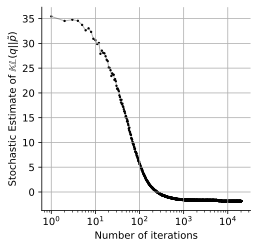

In [191]:
fig = plt.figure(figsize=(3.75, 3.75))
plt.plot(np.arange(1, len(sample_kls) + 1), sample_kls, linewidth=1, color="black", alpha=0.3)
plt.scatter(np.arange(1, len(sample_kls) + 1), sample_kls, s=2, color="black")

plt.ylabel(r"Stochastic Estimate of $\mathbb{KL}(q \vert \vert \tilde{p})$")
plt.xlabel("Number of iterations")
plt.gca().spines[['right', 'top']].set_visible(False)

plt.grid()
plt.xscale("log")
y_range = max(sample_kls) - min(sample_kls)
plt.ylim(min(sample_kls) - 1/20 * y_range, max(sample_kls) + 1/20 * y_range)

plt.show()

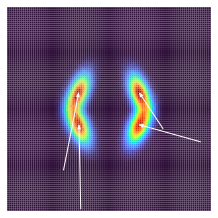

In [199]:
fig = plt.figure(figsize=(3.75, 3.75))

with torch.no_grad():
    q_samples = q.sample(N=int(1e6)).numpy()
    μs = q.μs.numpy()

plt.hist2d(q_samples[:,0], q_samples[:,1], bins=100, cmap="turbo", range=[[-6, 6], [-6, 6]])
for i, μ in enumerate(μs):
    plt.arrow(
        x = μs_init[i][0],
        y = μs_init[i][1],
        dx = μ[0] - μs_init[i][0],
        dy = μ[1] - μs_init[i][1],
        color="white",
        head_width=0.15,
        length_includes_head=True
    )

plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("attempt.png", dpi=300)

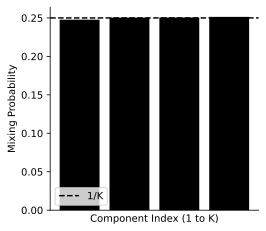

In [200]:
fig = plt.figure(figsize=(3.75, 3.75))
plt.bar(np.arange(K), q.π.detach().numpy(), color="black")
plt.axhline(1 / K, linestyle="--", color="black", label="1/K")

plt.xlabel("Component Index (1 to K)")
plt.ylabel("Mixing Probability")
plt.legend()
plt.gca().spines[['right', 'top']].set_visible(False)

plt.xticks([])

plt.show()